<a href="https://colab.research.google.com/github/paredesgr/Actividad-3.1/blob/main/Proyecto_Final_Redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import keras
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Embedding, LSTM
from keras import regularizers, layers, preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import itertools
from sklearn.metrics import confusion_matrix

In [2]:
#Montar drive donde tengo los archivos con 100 genes KatG de sepas resistentes a INH y 100 susceptibles a INH

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#Cargo el archivo de genes resistentes y le asigno la columna del gen y una columna nueva al inicio, con True indicando que es resistente
katg_resistentes = pd.read_csv('gdrive/MyDrive/Proyecto Final Redes/ResKatg.fas', header = None)
katg_resistentes_titulos = pd.DataFrame(katg_resistentes.values, columns = ["KatG"])
katg_resistentes_titulos.insert(0, 'resistant', 'True')
print (katg_resistentes_titulos)

#Cargo el archivo de genes susceptibles y le asigno la columna del gen y una columna nueva al inicio, con False indicando que es susceptible
katg_sensibles = pd.read_csv('gdrive/MyDrive/Proyecto Final Redes/SenKatg.fas', header = None)
katg_sensibles_titulos = pd.DataFrame(katg_sensibles.values, columns = ["KatG"])
katg_sensibles_titulos.insert(0, 'resistant', 'False')
print (katg_sensibles_titulos)

#Concat a los dos archivos generados
DataDf = pd.concat([katg_resistentes_titulos, katg_sensibles_titulos], axis=0)

print(DataDf)

#Crear un archivo csv a partir del dataframe.
DataDf.to_csv(r'RSKATG.csv', index=False,header=True)

   resistant                                               KatG
0       True  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...
1       True  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...
2       True  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...
3       True  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...
4       True  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...
..       ...                                                ...
95      True  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...
96      True  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...
97      True  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...
98      True  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...
99      True  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...

[100 rows x 2 columns]
   resistant                                               KatG
0      False  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...
1      False  gtgcccgagcaacacccacccattacagaaaccaccaccggagccg...
2      False  gt

(200, 2)


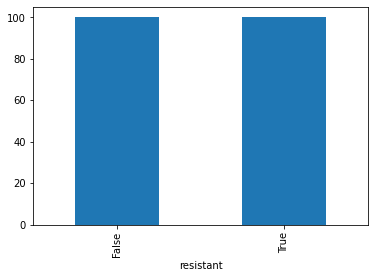

Found 4 unique tokens.
word_index {'g': 1, 'c': 2, 'a': 3, 't': 4}
(200, 2223)
(200,)


In [4]:
#read al archivo csv con los contigs de KatG
DataDf = pd.read_csv('RSKATG.csv')
print(DataDf.shape)
DataDf

# observar si los datos estan balanceados

DataDf.groupby('resistant').size().plot.bar()
plt.show()


# Tokenize: esta funcion la utilizo aqui para cambiar de un caracter en este caso las letras que representan los nucleotidos de la secuencia
# G,C,A y T, y los representamos como numeros enteros, como se muestra en el resultados.

Datatok = DataDf.copy()
maxlen = 2223  # longitud del gen KatG

caracteres = 5
features = caracteres

tokenizer = Tokenizer(num_words=caracteres, char_level=True)
tokenizer.fit_on_texts(list(Datatok['KatG']))
sequences = tokenizer.texts_to_sequences(list(Datatok['KatG']))
word_index = tokenizer.word_index
Xpad = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

print('Found %s unique tokens.' % len(word_index))
print('word_index', word_index)

# Separar las etiquetas (Resistentes y Susceptibles)

labels = np.asarray(Datatok['resistant'])
print(Xpad.shape)
print(labels.shape)

In [5]:
# Revisa una muestra

rowNum = 8
print(Datatok['KatG'][rowNum])
print(sequences[rowNum])

gtgcccgagcaacacccacccattacagaaaccaccaccggagccgctagcaacggctgtcccgtcgtgggtcatatgaaataccccgtcgagggcggcggaaaccaggactggtggcccaaccggctcaatctgaaggtactgcaccaaaacccggccgtcgctgacccgatgggtgcggcgttcgactatgccgcggaggtcgcgaccatcgacgttgacgccctgacgcgggacatcgaggaagtgatgaccacctcgcagccgtggtggcccgccgactacggccactacgggccgctgtttatccggatggcgtggcacgctgccggcacctaccgcatccacgacggccgcggcggcgccgggggcggcatgcagcggttcgcgccgcttaacagctggcccgacaacgccagcttggacaaggcgcgccggctgctgtggccggtcaagaagaagtacggcaagaagctctcatgggcggacctgattgttttcgccggcaactgcgcgctggaatcgatgggcttcaagacgttcgggttcggcttcggccgggtcgaccagtgggagcccgatgaggtctattggggcaaggaagccacctggctcggcgatgagcgttacagcggtaagcgggatctggagaacccgctggccgcggtgcagatggggctgatctacgtgaacccggaggggccgaacggcaacccggaccccatggccgcggcggtcgacattcgcgagacgtttcggcgcatggccatgaacgacgtcgaaacagcggcgctgatcgtcggcggtcacactttcggtaagacccatggcgccggcccggccgatctggtcggccccgaacccgaggctgctccgctggagcagatgggcttgggctggaagagctcgtatggcaccggaaccggtaaggacgcgatcaccaccggcatcgaggtcgtatggacgaacaccccgacgaaatgggacaacagtttcctcg

In [6]:
# Crea datos de entrenamiento y validacion

training_samples = int(Xpad.shape[0] * 0.8)

indices = np.arange(Xpad.shape[0])
np.random.shuffle(indices) 
Xpad = Xpad[indices]
labels = labels[indices]

x_train = Xpad[:training_samples]
y_train = labels[:training_samples]
x_test = Xpad[training_samples: ]
y_test = labels[training_samples: ]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (160, 2223)
y_train (160,)
x_test (40, 2223)
y_test (40,)


In [7]:
# Modelo

model = Sequential()
# La funcion Embedding se utiliza principalmente en el procesamiento de lenguaje natural, practicamente es representar una palabra en un vector,
# en este caso, al estar trabajando con texto decidi agregarlo para comprobar su desempeño, agrupando las "palabras" que serian en este caso
# espacios de 4 digitos debido a la cantidad de nucleotidos encontrados en una secuencia de DNA.

# 3 capas ocultas, 128 CNN con 27,18 y 9 de ventana respectivamente

#Funcion Bidirectional para que aprenda de la secuencia en ambas direcciones.

model.add(Embedding(5, 1, input_length=maxlen))
model.add(layers.Conv1D(128, 27, activation='relu'))
model.add(layers.MaxPooling1D(4))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 18, activation='relu'))
model.add(layers.MaxPooling1D(4))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2223, 1)           5         
                                                                 
 conv1d (Conv1D)             (None, 2197, 128)         3584      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 549, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 549, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 532, 128)          295040    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 133, 128)         0         
 1D)                                                    

In [8]:
# Entrenamiento del modelo

history = model.fit(x_train, y_train, batch_size=32, epochs = 30)

Epoch 1/30
5/5 [==============================] - 9s 1s/step - loss: 0.6966 - acc: 0.4563
Epoch 2/30
5/5 [==============================] - 5s 990ms/step - loss: 0.6938 - acc: 0.4625
Epoch 3/30
5/5 [==============================] - 5s 993ms/step - loss: 0.6951 - acc: 0.5000
Epoch 4/30
5/5 [==============================] - 5s 985ms/step - loss: 0.6982 - acc: 0.4313
Epoch 5/30
5/5 [==============================] - 5s 977ms/step - loss: 0.6938 - acc: 0.4688
Epoch 6/30
5/5 [==============================] - 5s 992ms/step - loss: 0.6935 - acc: 0.4938
Epoch 7/30
5/5 [==============================] - 5s 974ms/step - loss: 0.6934 - acc: 0.4750
Epoch 8/30
5/5 [==============================] - 5s 976ms/step - loss: 0.6931 - acc: 0.4750
Epoch 9/30
5/5 [==============================] - 5s 981ms/step - loss: 0.6937 - acc: 0.4875
Epoch 10/30
5/5 [==============================] - 5s 976ms/step - loss: 0.6934 - acc: 0.4875
Epoch 11/30
5/5 [==============================] - 5s 974ms/step - loss:

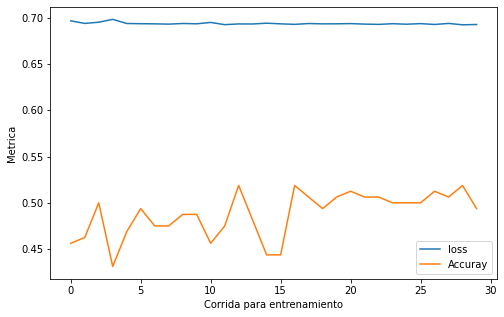

In [9]:
# Curva de aprendizaje 
pd.DataFrame(history.history).plot(figsize=(8, 5))

plt.ylabel('Metrica')
plt.xlabel('Corrida para entrenamiento')
plt.gca().legend(('loss','Accuray'))
plt.show()

In [13]:
# Prediccion final 
final_predictions = model.predict(x_test)
print(final_predictions)

Pred = final_predictions.copy()
print(len(Pred))

Pred[ np.where(Pred >= 0.5 ) ] = 1
Pred[ np.where(Pred < 0.5 ) ] = 0
print(Pred)

[[0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]
 [0.50643206]]
40
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


TP:  0
FP:  0
FN:  21
TN:  19
Sensibilidad: 0.0
Especificidad: 1.0


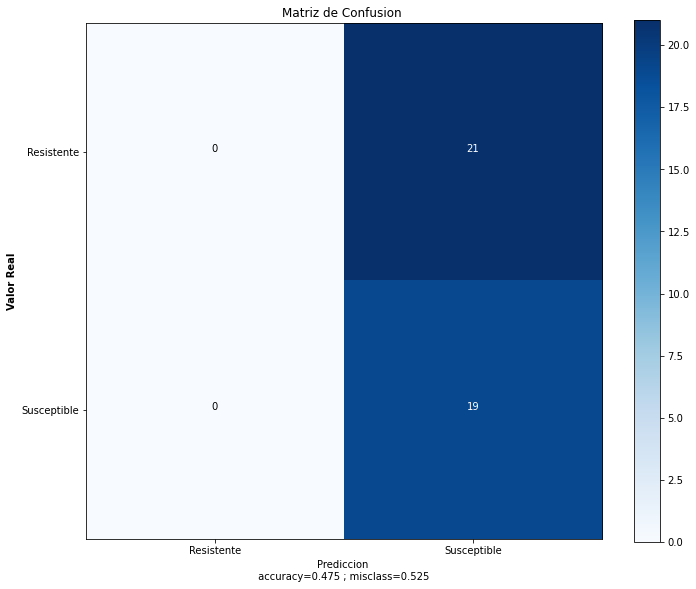

In [22]:
# Matriz de confusión 

conf_mx = confusion_matrix(y_test, Pred)

TP = conf_mx[0,0] # Verdedaero Positivo
FN = conf_mx[0,1] # Falso Positivo
FP = conf_mx[1,0] # Falso Negativo
TN = conf_mx[1,1] # Verdadero Negativo

print ('TP: ', TP)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TN: ', TN)

Sensibilidad = TP/(TP+FN)
Especificidad = TN/(TN+FP)

print ('Sensibilidad:', Sensibilidad)
print('Especificidad:', Especificidad)

# funcion para graficar 

def plot_matriz_confusion(mc,target_names,title='Matriz de Confusion',cmap='Blues',
                          normalize=False):
  
    accuracy = np.trace(mc) / float(np.sum(mc))
    misclass = 1 - accuracy

    plt.figure(figsize=(10, 8))
    plt.imshow(mc, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        mc = mc.astype('float') / mc.sum(axis=1)[:, np.newaxis]
    
    thresh = mc.max() / 1.5 if normalize else mc.max() / 2
    for i, j in itertools.product(range(mc.shape[0]), range(mc.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if mc[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(mc[i, j]),
                     horizontalalignment="center",
                     color="white" if mc[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Valor Real', fontweight = 'bold')
    plt.xlabel('Prediccion \n accuracy={:0.3f} ; misclass={:0.3f} '.format(accuracy, misclass))
    plt.show()
    
plot_matriz_confusion(conf_mx, normalize= False, target_names = ['Resistente', 'Susceptible'], title = "Matriz de Confusion ")